# 0. Importations 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
print(f"Chemin vers le dossier actuel: \n {os.getcwd()}")
path_main_folder = '/content/drive/My Drive/lyrics_generation/data/'

os.chdir(path_main_folder)
print(f"Chemin vers le dossier actuel: \n {os.getcwd()}")

Chemin vers le dossier actuel: 
 /content
Chemin vers le dossier actuel: 
 /content/drive/My Drive/lyrics_generation/data


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import pickle
import torch.nn.functional as F

from argparse import Namespace
import random
import string
import io
import sys, os

import math  
import seaborn as sns

Define device

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 0. Data Analysis

## 0.A) Exploration

In [0]:
df = pd.read_csv("songdata.csv")
df = df.drop(columns="link")

In [6]:
df.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante","Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [7]:
df.shape

(57650, 3)

In [8]:
df.artist.value_counts()

Donna Summer        191
Gordon Lightfoot    189
George Strait       188
Bob Dylan           188
Alabama             187
                   ... 
Exo-K                 2
Zed                   1
X-Treme               1
U-Kiss                1
Zoe                   1
Name: artist, Length: 643, dtype: int64

In [0]:
df['len_text']= df.text.apply(len)

In [10]:
df.len_text.describe()

count    57650.000000
mean      1179.504892
std        575.705050
min        400.000000
25%        784.000000
50%       1052.000000
75%       1415.000000
max       3997.000000
Name: len_text, dtype: float64

In [11]:
#Sample lyrics
print(df.text[122])

I'm never gonna say I'm sorry,  
I'm a clown for everyone  
I'm never gonna let you down,  
I'm always here like a sun  
  
I'm a looser, that is a fact for sure  
I'm happy even if you don't want  
To invite me out for a dance tonight  
I'm not normal, I know, I don't care  
I'm never gonna say  
  
I'm always here like a sun, I'm always here  
Like a ghost I follow your steps so true  
You don't have to bribe me or fill me up  
Give me just a minute to shine with you  
I will make you so happy, make you laugh  
I'm never gonna say I'm sorry for  
  
The essence of my soul  
There's so many ways to change my life  
'Cause I want to, oh  
I'm like a clown, I'm fun for everyone,  
I'm never gonna say I'm sorry




In [12]:
df.text[1]

"Take it easy with me, please  \nTouch me gently like a summer evening breeze  \nTake your time, make it slow  \nAndante, Andante  \nJust let the feeling grow  \n  \nMake your fingers soft and light  \nLet your body be the velvet of the night  \nTouch my soul, you know how  \nAndante, Andante  \nGo slowly with me now  \n  \nI'm your music  \n(I am your music and I am your song)  \nI'm your song  \n(I am your music and I am your song)  \nPlay me time and time again and make me strong  \n(Play me again 'cause you're making me strong)  \nMake me sing, make me sound  \n(You make me sing and you make me)  \nAndante, Andante  \nTread lightly on my ground  \nAndante, Andante  \nOh please don't let me down  \n  \nThere's a shimmer in your eyes  \nLike the feeling of a thousand butterflies  \nPlease don't talk, go on, play  \nAndante, Andante  \nAnd let me float away  \n  \nI'm your music  \n(I am your music and I am your song)  \nI'm your song  \n(I am your music and I am your song)  \nPlay me

In [13]:
#Nombre de retours à la ligne (dont les sauts de paragraphes)
df.text[13].count('\n')

56

In [14]:
#Nombre de sauts de ligne (nombre de paragraphes - 1)
df.text[13].count('\n  \n')

9

In [15]:
#Une fin de chanson se traduit par '\n\n'
df.text[122].split('\n  \n')

["I'm never gonna say I'm sorry,  \nI'm a clown for everyone  \nI'm never gonna let you down,  \nI'm always here like a sun  ",
 "I'm a looser, that is a fact for sure  \nI'm happy even if you don't want  \nTo invite me out for a dance tonight  \nI'm not normal, I know, I don't care  \nI'm never gonna say  ",
 "I'm always here like a sun, I'm always here  \nLike a ghost I follow your steps so true  \nYou don't have to bribe me or fill me up  \nGive me just a minute to shine with you  \nI will make you so happy, make you laugh  \nI'm never gonna say I'm sorry for  ",
 "The essence of my soul  \nThere's so many ways to change my life  \n'Cause I want to, oh  \nI'm like a clown, I'm fun for everyone,  \nI'm never gonna say I'm sorry\n\n"]

In [16]:
#Nombre de lignes par paragraphes
print([x.replace('\n\n','').count('\n') + 1 for x in df.text[13].split('\n  \n')])

[6, 6, 4, 4, 6, 6, 4, 4, 4, 2]


## 0.B) Calculate some characteristics

In [0]:
def get_nb_moy_lignes_par_para(x):
  """Calculate the mean number of lines in a paragraph"""
  #Compter la dernière ligne (+1)
  lignes_par_para = [t.replace('\n\n','').count('\n') + 1 for t in x.split('\n  \n')]
  return math.ceil(np.mean(lignes_par_para))

def get_lignes(x):
  """Return a list of the lines of a song"""
  #Split in lines
  lines = x.split('\n')
  # Remove trailing spaces
  r = [j.strip() for j in lines]
  # Remove empty lines
  return [x for x in r if len(x)>0]

def get_len_moy_ligne(x):
  """Calculate average length of a line"""
  # Calculate len of lines
  len_lines= [len(r) for r in x]
  # Return mean length
  return math.ceil(np.mean(len_lines))

def get_nb_repeated_lines(x):
  """Calculate the number of lines that are repeated"""
  d = dict(Counter(x))
  return sum(1 for i in d.values() if i >= 2)
  

In [0]:
df['nb_songs']=df.groupby('artist').count()['song']
df['lignes']=df.text.apply(get_lignes)
df['nb_paragrahes']= df.text.apply(lambda x: x.count('\n  \n')+1)
df['nb_moy_lignes_par_para'] = df.text.apply(get_nb_moy_lignes_par_para)
df['nb_lignes']=df.lignes.apply(len)
df['len_moy_ligne']= df.lignes.apply(get_len_moy_ligne)
df['nb_repeated_lines']= df.lignes.apply(get_nb_repeated_lines)

In [19]:
# Simple check
df.iloc[122,:]

artist                                                          Ace Of Base
song                                              Never Gonna Say I'm Sorry
text                      I'm never gonna say I'm sorry,  \nI'm a clown ...
len_text                                                                720
nb_songs                                                                NaN
lignes                    [I'm never gonna say I'm sorry,, I'm a clown f...
nb_paragrahes                                                             4
nb_moy_lignes_par_para                                                    5
nb_lignes                                                                20
len_moy_ligne                                                            33
nb_repeated_lines                                                         0
Name: 122, dtype: object

In [21]:
# Get mean values for each artist
artists_df = df.groupby('artist').mean()
#artists_df = artists_df.astype(int)
artists_df['nb_songs'] = df.groupby('artist').count()['song']
artists_df.head()

,len_text,nb_songs,nb_paragrahes,nb_moy_lignes_par_para,nb_lignes,len_moy_ligne,nb_repeated_lines
artist,,,,,,,
'n Sync,1432.580645,93,7.763441,8.075269,45.666667,29.032258,6.225806
ABBA,1340.168142,113,6.212389,7.486726,38.336283,32.672566,7.504425
Ace Of Base,1288.608108,74,8.459459,6.959459,42.864865,27.648649,6.581081
Adam Sandler,1475.571429,70,7.571429,13.500000,41.342857,33.328571,2.000000
Adele,1523.296296,54,7.740741,6.814815,46.425926,31.203704,8.314815


In [22]:
artists_df.describe()

,len_text,nb_songs,nb_paragrahes,nb_moy_lignes_par_para,nb_lignes,len_moy_ligne,nb_repeated_lines
count,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000
mean,1227.661056,89.657854,6.263098,10.392282,36.150251,31.936996,4.654758
std,453.488452,54.689192,2.095939,5.624701,11.278775,4.239746,1.856872
min,469.000000,1.000000,1.000000,3.892857,16.000000,20.500000,0.000000
25%,959.271552,41.000000,4.996552,6.846320,28.738519,29.003401,3.462657
50%,1110.049180,86.000000,6.153846,8.759740,33.579618,31.459459,4.428571
75%,1337.497692,141.000000,7.395815,12.065913,40.885344,33.939292,5.678408
max,3134.571429,191.000000,24.750000,46.857143,75.836066,57.000000,13.000000


In [25]:
# Number of artists
len(artists_df.index)

643

In [0]:
def get_topk(k, df):
  l = df.artist.value_counts()
  return l[:k].index.tolist()

## 0.C) Plot characteristics

Plot characteristics for one artist

Text(0.5, 1.0, 'Characteristics for Coldplay songs')

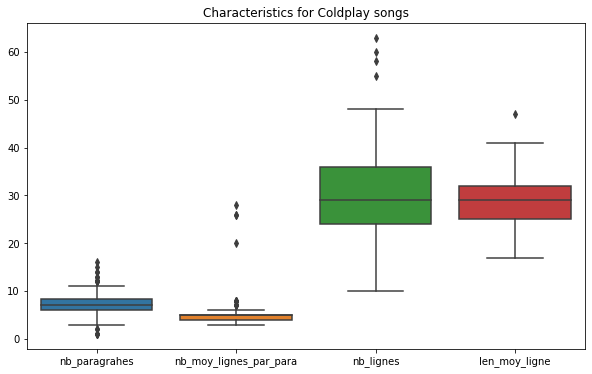

In [27]:
plt.figure(figsize=(10, 6))
artist = 'Coldplay'
sns.boxplot(data=df[df.artist==artist].iloc[:,5:-1])
plt.title("Characteristics for {} songs".format(artist))

Compare one characteristic between artists

Text(0.5, 1.0, 'Compare artists on nb_paragrahes')

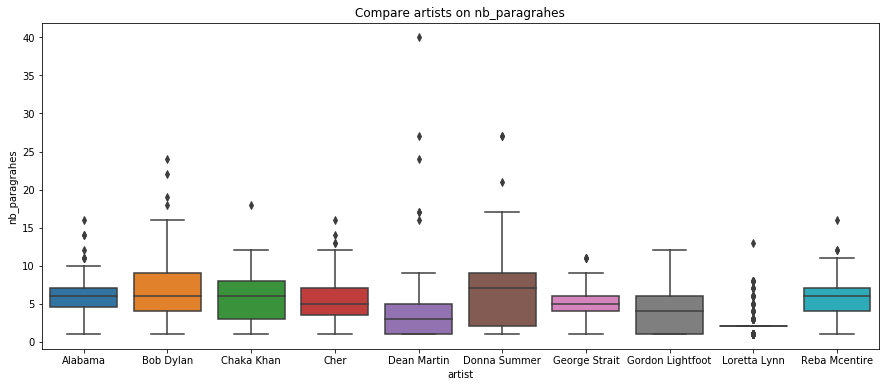

In [28]:
plt.figure(figsize=(15, 6))
characteristic = "nb_paragrahes"
artists = get_topk(10, df)
df_to_show = df[df.artist.isin(artists)]
sns.boxplot(y=df[characteristic], x=df_to_show.artist)
plt.title("Compare artists on {}".format(characteristic))

Plot one characteristic

Text(0, 0.5, 'Number of songs')

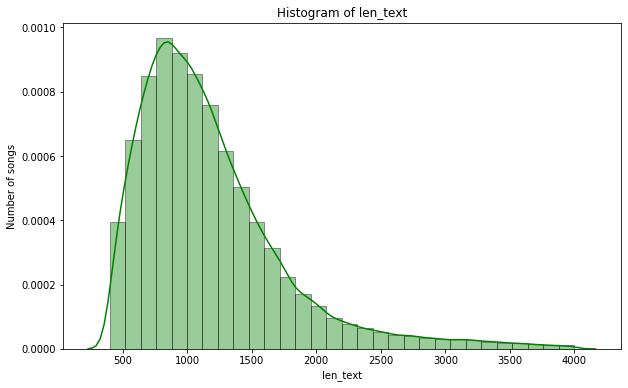

In [29]:
plt.figure(figsize=(10, 6))
characteristic = 'len_text'
sns.distplot(df[characteristic], hist=True, kde=True, 
             bins=30, color = 'green',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of {}'.format(characteristic))
plt.xlabel(characteristic)
plt.ylabel('Number of songs')

Compare all characteristics between all artists

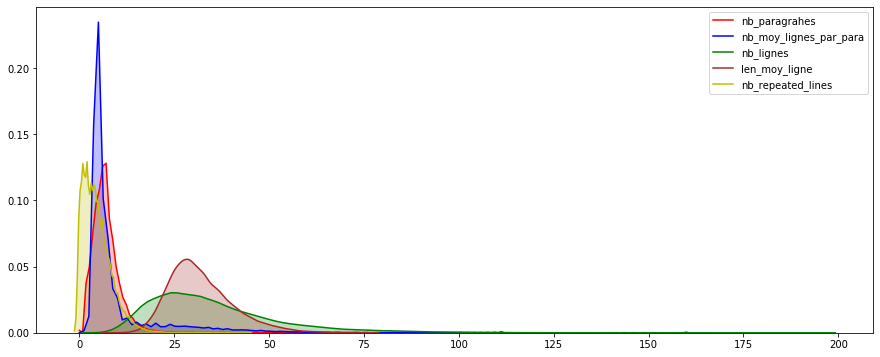

In [30]:
plt.figure(figsize=(15, 6))
p1=sns.kdeplot(df['nb_paragrahes'], shade=True, color="r")
p1=sns.kdeplot(df['nb_moy_lignes_par_para'], shade=True, color="b")
p1=sns.kdeplot(df['nb_lignes'], shade=True, color="g")
p1=sns.kdeplot(df['len_moy_ligne'], shade=True, color="brown")
p1=sns.kdeplot(df['nb_repeated_lines'], shade=True, color="y")

Text(0.5, 1.0, 'Compare all artists on all characteristics')

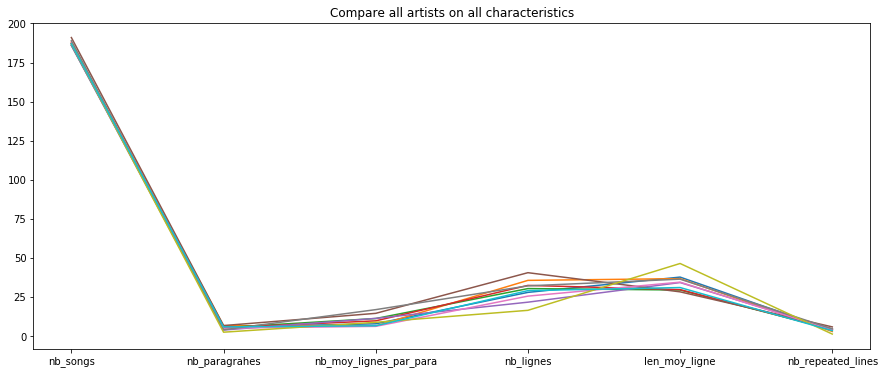

In [31]:
plt.figure(figsize=(15, 6))
artists = get_topk(10, df)
plot_artists_to_show = artists_df[artists_df.index.isin(artists)]
plt.plot(plot_artists_to_show.drop(columns=['len_text']).T)
#plt.legend(plot_artists_to_show.columns)
plt.title("Compare all artists on all characteristics")

In [33]:
plot_artists_to_show

,len_text,nb_songs,nb_paragrahes,nb_moy_lignes_par_para,nb_lignes,len_moy_ligne,nb_repeated_lines
artist,,,,,,,
Alabama,1087.224599,187,5.764706,7.866310,27.973262,37.748663,3.764706
Bob Dylan,1384.382979,188,6.659574,6.468085,35.654255,36.760638,2.952128
Chaka Khan,968.682796,186,5.446237,11.247312,30.397849,29.489247,4.225806
Cher,1044.663102,187,5.368984,9.764706,32.433155,29.737968,4.278075
Dean Martin,785.080645,186,3.881720,11.333333,21.704301,34.258065,4.494624
Donna Summer,1240.356021,191,6.748691,14.554974,40.570681,28.308901,5.884817
George Strait,934.047872,188,5.106383,6.228723,25.574468,34.521277,3.957447
Gordon Lightfoot,1218.925926,189,4.031746,16.936508,32.142857,36.428571,4.650794
Loretta Lynn,787.668449,187,2.502674,8.834225,16.486631,46.454545,1.299465


Text(0.5, 1.0, 'Compare all artists on all characteristics')

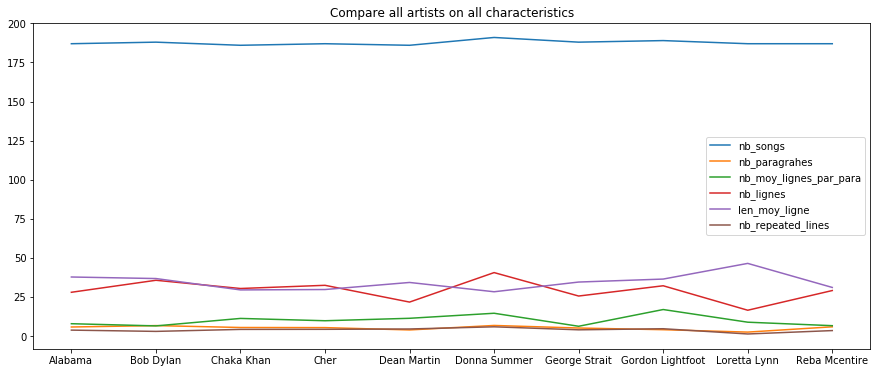

In [36]:
plt.figure(figsize=(15, 6))
artists = get_topk(10, df)
plot_artists_to_show = artists_df[artists_df.index.isin(artists)]
df2 = plot_artists_to_show.drop(columns=['len_text'])
plt.plot(df2)
plt.legend(df2.columns)
plt.title("Compare all artists on all characteristics")

Text(0.5, 1.0, 'Compare all artists on all characteristics')

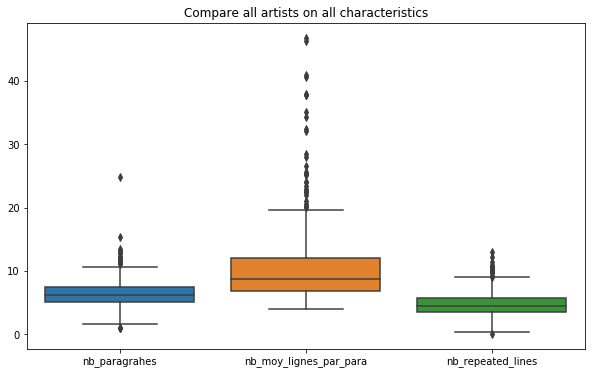

In [37]:
plt.figure(figsize=(10, 6))
df_plot = artists_df
sns.boxplot(data=df_plot.drop(columns=['nb_lignes','len_moy_ligne','len_text','nb_songs']))
plt.title("Compare all artists on all characteristics")

# 1. Text pre-processing 

In [0]:
def preprocess(text):
    #text = text.replace("'ll",' will')
    #text = text.replace("'m",' am')
    #text = text.replace("'re",' are')
    #text = text.replace("'s",' is')
    
    text = text.replace("\n"," \n ")
    text = text.lower()
    
    # Remove all words in-between () or []
    text = re.sub("[\(\[].*?[\)\]]", "", text)
   
    # Remove unwanted words
    unwanted_words = ['chorus\s*', 'verse\s*', 'intro\s*', 'outro\s*', 'bridge\s*','pre-chorus\s*','hook\s*']
    text = re.sub('({})'.format('|'.join(unwanted_words)),"",text.strip())
    
    # Remove numbers
    text = re.sub(r'[0-9\.]+', '', text)

    # Only keep one space
    text = re.sub(' {2,}', ' ', text)

    # Remove some punctiation
    punct_to_keep = ["'","!","?",","]
    punct_to_discard = [x for x in string.punctuation if x not in punct_to_keep]
    text = "".join(v for v in text if v not in punct_to_discard)
    
    #text = text.replace("\n"," \SAUT ")

    print ("Text length is : ", len(text))
    return text

def extract_characters(text):
    return sorted(list(set(text)))

def get_chars_index_dicts(chars):
    return dict((c, i) for i, c in enumerate(chars)), dict((i, c) for i, c in enumerate(chars))

In [422]:
#Check up
# word = 'chorus'

# def contains_word(x,word):
#   x = x.lower()
#   return word in x

# df_chorus.text.apply(lambda x: contains_word(x,"[intro]")).value_counts()

False    489
Name: text, dtype: int64

# 2. Vectorization

In [0]:
#Encode characters in numbers
def vectorize(sentence, char_to_index):
  return np.array([char_to_index[char] for char in sentence])

#Project a batch of int_sequences in dim chars space
def one_hot_encode(sequences, chars):
    X = np.zeros((len(sequences), len(sequences[0]), len(chars)), dtype=int)
    for i, sentence in enumerate(sequences):
        for t, integer in enumerate(sentence):
            X[i, t, integer] = 1
    return X

# def one_hot_encode(sequences, sequence_length, chars, char_to_index, next_chars):
#     X = np.zeros((len(sequences), sequence_length, len(chars)), dtype=int)
#     y = np.zeros((len(sequences), len(chars)), dtype=int)
#     for i, sentence in enumerate(sequences):
#         for t, char in enumerate(sentence):
#             X[i, t, char_to_index[char]] = 1
#         y[i, char_to_index[next_chars[i]]] = 1

#     return X, y

In [0]:
def show_batch(train_loader):
    # obtain one batch of training data
    dataiter = iter(train_loader)
    sample_x, sample_y = dataiter.next()
    print('Sample input size: ', sample_x.size()) # batch_size, seq_length
    print('Sample input: \n', sample_x)
    print()
    print('Sample output size: ', sample_y.size()) # batch_size
    print('Sample output: \n', sample_y)

# Data extraction

In [0]:
def get_data_from_file(train_file,artists_names=None):
    
    df = pd.read_csv(train_file)
    
    #Select artist
    if artists_names :
      df = df[df.artist.isin(artists_names)]
    
    print("Number of songs : ", len(df.index))

    #Get text
    text = ' '.join([x for x in df.text])

    #Transform data
    text = preprocess(text)
    
    #Get characters
    chars = extract_characters(text)

    #Get dictionnaries
    char_to_index, indices_char = get_chars_index_dicts(chars)

    #Encode text
    encoded_text = vectorize(text, char_to_index)

    return chars, encoded_text

# Create Batches

In [0]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [0]:
# def create_sequences(text, sequence_length, step):
#     sequences = []
#     next_chars = []
#     for i in range(0, len(text) - sequence_length, step):
#         sequences.append(text[i: i + sequence_length])
#         next_chars.append(text[i + sequence_length])
#     return sequences, next_chars

# def create_sequences(text, sequence_length, step):
#     text = text[:sequence_length * (len(text)//sequence_length)+2]
#     sequences = []
#     next_sequences = []
#     for i in range(0, len(text) - sequence_length-1, step):
#         sequences.append(text[i: i + sequence_length])
#         next_sequences.append(text[i+1: i + sequence_length+1])
#     return sequences, next_sequences

# 3. Create Model class and train function

## 3. A) LSTM

In [0]:
class LSTM(nn.Module):
    def __init__(self, chars, hidden_size=flags.hidden_size, num_layers=flags.n_layers, drop_prob=0.5, lr=0.001):
        super().__init__()
        self.chars = chars
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.lr = lr
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        # Define layers
        self.lstm = nn.LSTM(input_size=len(chars), hidden_size=hidden_size, num_layers=num_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_size, len(chars))
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x, hidden):
      # Hidden = h et c les états internes
      
      output, hidden = self.lstm(x, hidden)
  
      # Use dropout
      out = self.dropout(output)

      out = out.contiguous().view(-1, self.hidden_size)
      #x = x[:,-1,:]  # Keep only the output of the last iteration. Before shape (6,3,128), after shape (6,128)
      
      out = self.fc(out)
      #out = self.softmax(out)
      
      return out, hidden
    
      
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes nb_layers x batch_size x hidden_size,
        # initialized to zero, for hidden state and cell state of LSTM
        
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size, dtype=int).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size,dtype=int).to(device))
        
        return hidden

## 3. B) Train function

In [0]:
def train(model, data, batch_size=10, seq_length=40, nb_epochs=8000, lr=0.01, clip=5, val_frac=0.1, print_every=1):
  
  model = model.to(device)
  model.train()
  
  #criterion = nn.MSELoss()
  #criterion = nn.CategoricalCrossEntropy()
  criterion = nn.CrossEntropyLoss()
 
  #optimizer = torch.optim.RMSprop(model.parameters(), lr = lr)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  flags.optimizer = optimizer
  
  # Create training and validation data
  #TODO: cross-validation
  val_index = int(len(data)*(1-val_frac))
  train_data, val_data = data[:val_index], data[val_index:]

  counter = 0
  n_chars = len(model.chars)

  for epoch in range(nb_epochs):
    # initialize hidden state
    h = model.init_hidden(batch_size)

    #train_data = TensorDataset(torch.from_numpy(X).to(device), torch.from_numpy(y).to(device))
    #train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)

    for x, y in get_batches(data, batch_size, seq_length):
      
      counter+=1

      # One-hot encode our data and make them Torch tensors (only x data!!)  
      x = one_hot_encode(x, model.chars)


      inputs, targets = torch.from_numpy(x).float(), torch.from_numpy(y).float()
      
      inputs, targets = inputs.to(device), targets.to(device)
      
      # Creating new variables for the hidden state, otherwise
      # we'd backprop through the entire training history
      h = tuple([each.data.float() for each in h])
 
      model.zero_grad()

      output, h = model(inputs, h)
      
      loss = criterion(output, targets.view(batch_size*seq_length).long())
      #loss = criterion(output, targets)
      
      loss.backward()
      
      # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
      nn.utils.clip_grad_norm_(model.parameters(), clip)

      optimizer.step()

      # loss stats
      if counter % print_every == 0:
          # Get validation loss
          val_h = model.init_hidden(batch_size)
          val_losses = []
          model.eval()
          for x, y in get_batches(val_data, batch_size, seq_length):
              # One-hot encode our data and make them Torch tensors
              x = one_hot_encode(x, model.chars)
              inputs, targets = torch.from_numpy(x).float(), torch.from_numpy(y).float()
              
              # Creating new variables for the hidden state, otherwise
              # we'd backprop through the entire training history
              val_h = tuple([each.data.float() for each in val_h])
            
              inputs, targets = inputs.to(device), targets.to(device)

              output, val_h = model(inputs, val_h)
              val_loss = criterion(output, targets.view(batch_size*seq_length).long())
          
              val_losses.append(val_loss.item())
          
          model.train() # reset to train mode after iterationg through validation data
                
          print("Epoch: [{}/{}]".format(epoch+1, nb_epochs),
                "Step: [{}]".format(counter),
                "Loss: {:.4f}".format(loss.item()),
                "Val Loss: {:.4f}".format(np.mean(val_losses)))

    #print(f"Epoch {epoch+1}/{n_epochs}, loss = {loss.item()}")

# 4. Instantiate model

## 4. A) Pipeline : from text

In [0]:
flags = Namespace(
    train_file='songdata.csv',
    artists_names=['Coldplay'],
    n_epochs=10,
    batch_size=128,
    seq_length=40,
    hidden_size=256,
    gradients_norm=5,
    predict_top_k=5,
    checkpoint_path='checkpoint',
    n_layers=2,
    SEQUENCE_STEP = 1,
    DIVERSITY = 1.0,
    optimizer = None
)

In [86]:
chars, encoded_text = get_data_from_file(flags.train_file,flags.artists_names)

Number of songs :  120
Text length is :  113413


In [0]:
model = LSTM(chars,hidden_size=flags.hidden_size)

In [0]:
model =model.float()

In [93]:
#Train the model

train(model, encoded_text, batch_size=flags.batch_size, seq_length=flags.seq_length, nb_epochs=flags.n_epochs, lr=0.01, print_every=20)

Epoch: [1/10] Step: [20] Loss: 2.9139 Val Loss: 2.8826
Epoch: [2/10] Step: [40] Loss: 2.8089 Val Loss: 2.7943
Epoch: [3/10] Step: [60] Loss: 2.5431 Val Loss: 2.5134
Epoch: [4/10] Step: [80] Loss: 2.3039 Val Loss: 2.2502
Epoch: [5/10] Step: [100] Loss: 2.1557 Val Loss: 2.0626
Epoch: [6/10] Step: [120] Loss: 2.0272 Val Loss: 1.9395
Epoch: [7/10] Step: [140] Loss: 1.9074 Val Loss: 1.8270
Epoch: [8/10] Step: [160] Loss: 1.8100 Val Loss: 1.7331
Epoch: [9/10] Step: [180] Loss: 1.7587 Val Loss: 1.6524
Epoch: [10/10] Step: [200] Loss: 1.6840 Val Loss: 1.5871
Epoch: [10/10] Step: [220] Loss: 1.7392 Val Loss: 1.5324


# 5. Save Model

In [0]:
model_name = "10_epochs_coldplay"
PATH = "../models/" + model_name + ".net"

checkpoint = {'nb_epochs': 10,
              'n_hidden': model.hidden_size,
              'n_layers': model.num_layers,
              'model_state_dict': model.state_dict(),
              'tokens': model.chars,
              'optimizer_state_dict' : flags.optimizer.state_dict()}

torch.save(checkpoint, PATH)

# 6. Generate samples

## 6. A) Load model

In [99]:
import configparser as config
imported_model_name = "10_epochs_coldplay"
PATH = "../models/" + imported_model_name + ".net"

imported_model = LSTM(chars)

# if os.path.exists(PATH):
#      if config.resume:
checkpoint = torch.load(PATH)
imported_model.load_state_dict(checkpoint['model_state_dict'])

imported_model.eval()

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

LSTM(
  (lstm): LSTM(32, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=32, bias=True)
  (softmax): Softmax(dim=1)
)

## 6. B) Predict function

In [0]:
def predict(model, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        # tensor inputs
        x = np.array([[model.char2int[char]]])
        x = one_hot_encode(x, model.chars)
        inputs = torch.from_numpy(x).float()
        
        inputs = inputs.to(device)
        
        # detach hidden state from history
        h = tuple([each.data.float() for each in h])
        
        # get the output of the model
        out, h = model(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        
        p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(model.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return model.int2char[char], h

In [0]:
def sample(model, size, sentence='The', top_k=None):
    
    model = model.to(device)
    
    model.eval() # eval mode
    
    sentence = sentence.lower()

    chars = [ch for ch in sentence]
    
    h = model.init_hidden(1)
    
    for ch in sentence:
        char, h = predict(model, ch, h, top_k=top_k)
    
    #add last one
    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for i in range(size):
        char, h = predict(model, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [100]:
print(sample(imported_model, 1000, sentence='i\'ve come down', top_k=5))

i've come downs 
 and try to timing at 
 
 
 
 i con't light thit i light 
 
 the time 
 
 
 it's gonni wall op a croust 
 
 i don't tone 
 in'm gead think a whost one 
 and i could 
 to doung it's whot mingen 
 i wait you sead 
 
 there a leart 
 a was as you're whese? the songang, oh you that your warn 
 i'm song 
 that in the wattill 
 i can lages 
 
 oh 
 
 to that you try it to shich 
 that's mesting 
 i'm what's all in a song to deising 
 
 and all there a wat 
 that mant to the way 
 and a lide 
 
 i'm is my alone 
 
 and i want you're wook 
 and i way 
 it's me 
 
 there lise 
 that't loves a lotken 
 i know the skys the ticks 
 oh 
 a lead that it and i contise, and to the to see of the car 
 
 on trass to me i can to the warn 
 oh, i want, oh you see your 
 in the like to the what you samss in and thround and tele whin to me 
 in yauree 
 i wanted 
 
 the woald and and take 
 the want 
 
 i do 
 
 
 it's go 
 or the stard 
 the want, a wasnas it a songes 
 te we the sting 
 


In [290]:
for diversity in [0.2, 0.5, 1.0, 1.2]:
    print()
    print('----- diversity:', diversity)

    generated = ''
    # insert your 40-chars long string. OBS it needs to be exactly 40 chars!
    sentence = "Hey my lovely dear, i missed you so much"
    sentence = sentence.lower() #stop here-------------^"
    generated += sentence

    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(400):
        x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_to_index[char]] = 1
        x = torch.from_numpy(x)
        x = x.float()
        x = x.to(device)
        model.eval()
        #x_input = torch.tensor([70, 80, 90]).float().reshape((1, 3, 1))
        #yhat = model(x_input)
        #print(yhat)
        predictions = model(x)[0]
        predictions = predictions.cpu().detach()
        predictions = predictions.numpy()
        #next_index = sample(predictions, diversity)
        next_index = np.argmax(predictions)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


----- diversity: 0.2
----- Generating with seed: "hey my lovely dear, i missed you so much"
hey my lovely dear, i missed you so much

NameError: ignored

In [0]:
def sample(preds, temperature=1.0):
    preds =preds.cpu()
    preds = preds.detach()
    print(preds.shape)
    print(preds)
    if temperature == 0:
        temperature = 1

    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)